**Create Dataframe**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import wave
import sys
import os
import librosa
import librosa.display
import xgboost as xgb
from  sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import sklearn.naive_bayes as nb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier
from sklearn.neighbors import kd_tree
import seaborn as sn
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE


Using TensorFlow backend.


In [2]:
def create_dataframe(folder):
    soundwav = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.wav'):
                soundwav.append(file)
    data = [];
    
    for file in soundwav:
        if file[:3] not in data:
            data.append(file[:3])
    data = sorted(data)    
    row =[]
    
    for i in data :
        r1=[]
        for file in soundwav:
            if file[:3]==i:
                r1.append(file)
        row.append(r1)
                
    
    df=pd.DataFrame(row,index=data)
    col = []
    for i in range(1,df.shape[1]+1):
        col.append('soundtrack-'+str(i))
    
    df.columns = col

    return df

In [3]:
folder = "/kaggle/input/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database/"   

subfolder =folder  +'audio_and_txt_files/'
df = create_dataframe(subfolder)
df=df.rename_axis('ID')
soundpath=[]
for i in df.iloc[:,0]:
    soundpath.append(subfolder+i)
diagnosis = pd.read_csv(folder+'patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])
soundtracks=df.count(axis=1)
parent_dir = folder
tr_sub_dirs = subfolder
ts_sub_dirs = subfolder+"test/"

df=df.rename_axis('ID')
print(df.head(10))


                   soundtrack-1                soundtrack-2  \
ID                                                            
101  101_1b1_Pr_sc_Meditron.wav  101_1b1_Al_sc_Meditron.wav   
102  102_1b1_Ar_sc_Meditron.wav                        None   
103  103_2b2_Ar_mc_LittC2SE.wav                        None   
104  104_1b1_Lr_sc_Litt3200.wav  104_1b1_Ll_sc_Litt3200.wav   
105  105_1b1_Tc_sc_Meditron.wav                        None   
106  106_2b1_Pr_mc_LittC2SE.wav  106_2b1_Pl_mc_LittC2SE.wav   
107  107_3p2_Tc_mc_AKGC417L.wav  107_2b4_Tc_mc_AKGC417L.wav   
108  108_1b1_Al_sc_Meditron.wav                        None   
109  109_1b1_Lr_sc_Litt3200.wav  109_1b1_Pr_sc_Litt3200.wav   
110  110_1p1_Pr_sc_Meditron.wav  110_1p1_Al_sc_Meditron.wav   

                   soundtrack-3                soundtrack-4  \
ID                                                            
101                        None                        None   
102                        None                       

**Load Sound data**


based on the CNN: Detection of wheezes and crackles kernel

In [4]:
import wave
import math
import scipy.io.wavfile as wf
import numpy as np
#wave file reader

#Will resample all files to the target sample rate and produce a 32bit float array
def read_wav_file(str_filename, target_rate):
    wav = wave.open(str_filename, mode = 'r')
    (sample_rate, data) = extract2FloatArr(wav,str_filename)
    
    if (sample_rate != target_rate):
        ( _ , data) = resample(sample_rate, data, target_rate)
        
    wav.close()
    return (target_rate, data.astype(np.float32))

def resample(current_rate, data, target_rate):
    x_original = np.linspace(0,100,len(data))
    x_resampled = np.linspace(0,100, int(len(data) * (target_rate / current_rate)))
    resampled = np.interp(x_resampled, x_original, data)
    return (target_rate, resampled.astype(np.float32))

# -> (sample_rate, data)
def extract2FloatArr(lp_wave, str_filename):
    (bps, channels) = bitrate_channels(lp_wave)
    
    if bps in [1,2,4]:
        (rate, data) = wf.read(str_filename)
        divisor_dict = {1:255, 2:32768}
        if bps in [1,2]:
            divisor = divisor_dict[bps]
            data = np.divide(data, float(divisor)) #clamp to [0.0,1.0]        
        return (rate, data)
    
    elif bps == 3: 
        #24bpp wave
        return read24bitwave(lp_wave)
    
    else:
        raise Exception('Unrecognized wave format: {} bytes per sample'.format(bps))
        
#Note: This function truncates the 24 bit samples to 16 bits of precision
#Reads a wave object returned by the wave.read() method
#Returns the sample rate, as well as the audio in the form of a 32 bit float numpy array
#(sample_rate:float, audio_data: float[])
def read24bitwave(lp_wave):
    nFrames = lp_wave.getnframes()
    buf = lp_wave.readframes(nFrames)
    reshaped = np.frombuffer(buf, np.int8).reshape(nFrames,-1)
    short_output = np.empty((nFrames, 2), dtype = np.int8)
    short_output[:,:] = reshaped[:, -2:]
    short_output = short_output.view(np.int16)
    return (lp_wave.getframerate(), np.divide(short_output, 32768).reshape(-1))  #return numpy array to save memory via array slicing

def bitrate_channels(lp_wave):
    bps = (lp_wave.getsampwidth() / lp_wave.getnchannels()) #bytes per sample
    return (bps, lp_wave.getnchannels())

In [5]:
def load_sound_files(file_paths):
    raw_sounds = []
    raw_sr = []
    for fp in file_paths:
        sr,X = read_wav_file(fp,22000)
        #reduced_noise = nr.reduce_noise(audio_clip=X, noise_clip=X, verbose=False)# Visualize
        raw_sr.append(sr)
        raw_sounds.append(X)
    return raw_sounds,raw_sr

In [6]:
def encode(line):
    if line[0]==0:
        if line[1]==0:
            return 0
        else: 
            return 2
    if line[0]==1:
        if line[1]==0:
            return 1
        else:
            return 3
        
def frame(lengths):
    times=[]
    labels=[]
    for df in lengths:
        l=df.iloc[:,0:2]
        l=l.to_numpy();      
        l=l.reshape(1,-1)
        l=np.ceil(l*22050)
        l=l.reshape(int(l.size/2),-1)
        times.append(l)
        # 0 present of crackle 1 present of wheeles 2 both
        #0 0 0 or 0 0 1 or 0 1 0 or 1 0 0
        k=df.iloc[:,2:4]
        k=k.to_numpy()
        z=[]
        for i in k:
            z.append(encode(i))
        z=np.asarray(z)
        z=z.reshape(-1,1)
        labels.append(z)
    return times,labels
def w_c_dataset(df,subfolder):
    files=[]
    lengths=[]
    for i,j in df.iterrows():
        for l in j:
            if(l!=None):
                files.append(subfolder+str(l))
                a=str(l).replace('.wav','.txt')
                tmp=pd.read_csv(subfolder+a,sep='\t',header = None)
                lengths.append(tmp)
                times,labels=frame(lengths)    
    [sound,sr] = load_sound_files(files)
    return sound,sr,lengths,times,labels
def split_sounds(sounds,times,labels):
    s=[]
    l=[]
    for i,sound in enumerate(sounds):
        for t,label in zip(times[i],labels[i]):
            s.append(sound[int(t[0]):int(t[1])])
            if label==0:
                a=np.array([1,0,0,0])
            if label==1:
                a=np.array([0,1,0,0])
            if label==2:
                a=np.array([0,0,1,0])    
            if label==3:
                a=np.array([0,0,0,1])
            l.append(a)
    return s,l

In [7]:
[sound,sr,lengths,times,labels] = w_c_dataset(df,subfolder)
[data,label]=split_sounds(sound,times,labels)

**Feature Extraction**

We take statistical features from MFCCs. The reason we do that is the different length of the audio clips.
For each clip we take 50 coefficients and we take std and mean for each band. Those are our features for the classifier.
We will upload a second approach with BOAW, but it didn't perform well.

In [8]:
import librosa
def extract_feature(X,sample_rate):
    
    n_fft=int(sample_rate*0.025)
    hop_length=int(sample_rate*0.01)
    
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate,n_fft=n_fft,hop_length=hop_length,
                                         n_mfcc=50)
    mean_mfcc = np.mean(mfcc.T,axis=0)
    std_mfcc = np.std(mfcc.T,axis=0)
#    p10 = np.percentile(mfcc.T,10,axis=0)
#    p25 = np.percentile(mfcc.T,25,axis=0)
#    p50 = np.percentile(mfcc.T,50,axis=0)
#    p75 = np.percentile(mfcc.T,75,axis=0)
#    p90 = np.percentile(mfcc.T,90,axis=0)
    

    return np.vstack((mean_mfcc,std_mfcc))

In [9]:
dataset = []
for d in data:
    a = extract_feature(d,sr[0])
    dataset.append(a)

data=np.asarray(dataset)
data = data.reshape([6898,data.shape[1]*data.shape[2],])

label=np.asarray(label)
a=np.zeros(label.shape[0])
for i in range(label.shape[0]):
    for j in range(label.shape[1]):
        if label[i][j]==1:
            a[i]=j

In [10]:
scaler=StandardScaler()
x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(data,a,test_size=0.3, random_state=42,stratify=a)
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

**SVM Classifier**

with RBF kernel grid search and best hyperparameters

grid search approach. For convenience in execution time we don't run it again.

In [11]:
'''
    Cs = [2**(-2),2**(-1), 1,2**(1),2**(2),2**(3),2**(4),2**(5),2**(6),2**(7),2**(8),2**(9),2**(10)]
    gamma = [2**(-7),2**(-6),2**(-5),2**(-4),2**(-3),2**(-2),2**(-1),2**(0),2**(1),2**(2),2**(3)]


    param_grid = {'C': Cs,  
                  'gamma': gamma, 
                  'kernel': ['rbf'],
                  'decision_function_shape':['ovr'],
                  'class_weight': ['balanced']}  
    grid1 = GridSearchCV(SVC(), param_grid,cv=3,n_jobs=-1, verbose = 3) 

    # fitting the model for grid search 
    grid1.fit(x_train, y_train)

    # print best parameter after tuning 
    print(grid1.best_params_) 
    # print how our model looks after hyper-parameter tuning 
    print(grid1.best_estimator_)

    grid_predictions = grid1.predict(x_test) 

    # print classification report 
    print(classification_report(y_test, grid_predictions))
    print(accuracy_score(y_test,grid_predictions))

    print(sklearn.metrics.confusion_matrix(y_test,grid_predictions))
'''

"\n    Cs = [2**(-2),2**(-1), 1,2**(1),2**(2),2**(3),2**(4),2**(5),2**(6),2**(7),2**(8),2**(9),2**(10)]\n    gamma = [2**(-7),2**(-6),2**(-5),2**(-4),2**(-3),2**(-2),2**(-1),2**(0),2**(1),2**(2),2**(3)]\n\n\n    param_grid = {'C': Cs,  \n                  'gamma': gamma, \n                  'kernel': ['rbf'],\n                  'decision_function_shape':['ovr'],\n                  'class_weight': ['balanced']}  \n    grid1 = GridSearchCV(SVC(), param_grid,cv=3,n_jobs=-1, verbose = 3) \n\n    # fitting the model for grid search \n    grid1.fit(x_train, y_train)\n\n    # print best parameter after tuning \n    print(grid1.best_params_) \n    # print how our model looks after hyper-parameter tuning \n    print(grid1.best_estimator_)\n\n    grid_predictions = grid1.predict(x_test) \n\n    # print classification report \n    print(classification_report(y_test, grid_predictions))\n    print(accuracy_score(y_test,grid_predictions))\n\n    print(sklearn.metrics.confusion_matrix(y_test,grid_pre

In [12]:
# best parameters
#{'C': 4, 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'gamma': 0.03125, 'kernel': 'rbf'}

model = SVC(kernel='rbf',class_weight='balanced',gamma=0.03125,C=4)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

print(sklearn.metrics.confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81      1093
         1.0       0.68      0.74      0.71       559
         2.0       0.72      0.53      0.61       266
         3.0       0.58      0.44      0.50       152

    accuracy                           0.74      2070
   macro avg       0.69      0.64      0.66      2070
weighted avg       0.74      0.74      0.74      2070

0.7405797101449275
[[909 152  25   7]
 [116 415   8  20]
 [ 86  17 142  21]
 [ 36  27  22  67]]


In [13]:
        
def onehenc(labels,classes=4):
    r=np.zeros((labels.shape[0],classes))
    for i in range(labels.shape[0]):
        for j in range(classes):
            if labels[i]==j:
                r[i,j]=1
    return r
def cm(y_test,y_pred):
    classes = ["none", "crackles", "wheezes", "both"] # put your class labels
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred,labels=range(4)), index = [i for i in classes],
                      columns = [i for i in classes])
    plt.figure(figsize = (10,7))
    plt.title('Confusion matrix')
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='d')
    
    
    plt.show()
    
def plot_roc(y_test,y_pred):
    
    test=onehenc(y_test,4)
    pred=onehenc(y_pred,4)
    
    
    # Compute ROC curve and ROC area for each class
    from sklearn.metrics import roc_auc_score,roc_curve,auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(test[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    
    # Plot of a ROC curve for a specific class
    for i in range(4):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot([1,0],[1,1])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="best")
        plt.show()

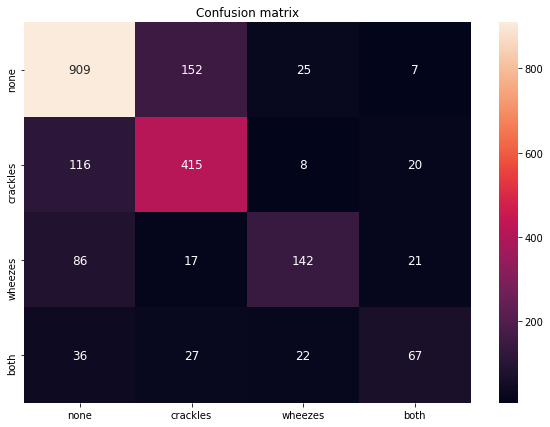

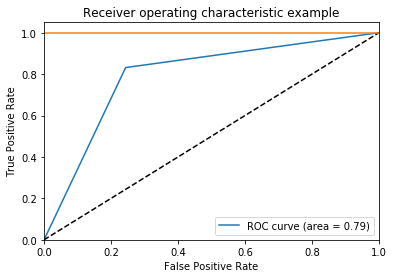

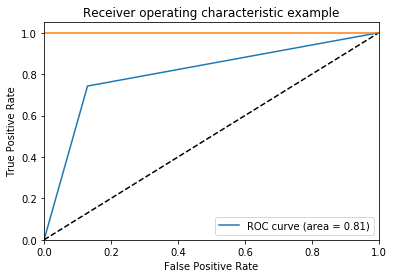

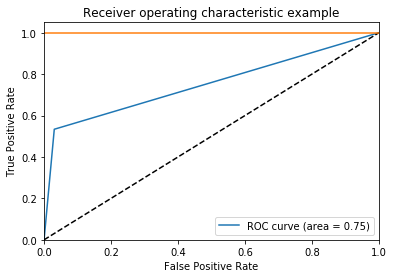

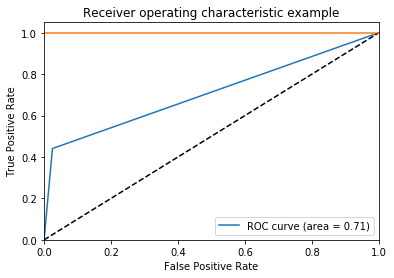

In [14]:
cm(y_test,y_pred)
plot_roc(y_test,y_pred)